# Decision Tree and Logistic Regression

The notebook demonstrates the model *DecisionTreeLogisticRegression* which replaces the decision based on one variable by a logistic regression.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Iris dataset and logistic regression

The following code shows the border defined by two machine learning models on the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html).

In [3]:
import numpy
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


def plot_classifier_decision_zone(clf, X, y, title=None, ax=None):
    
    if ax is None:
        ax = plt.gca()
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    dhx = (x_max - x_min) / 100
    dhy = (y_max - y_min) / 100
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, dhx),
                            numpy.arange(y_min, y_max, dhy))

    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.5)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', lw=0.5)
    if title is not None:
        ax.set_title(title)

        
iris = load_iris()
X = iris.data[:, [0, 2]]
y = iris.target
y = y % 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, shuffle=True)

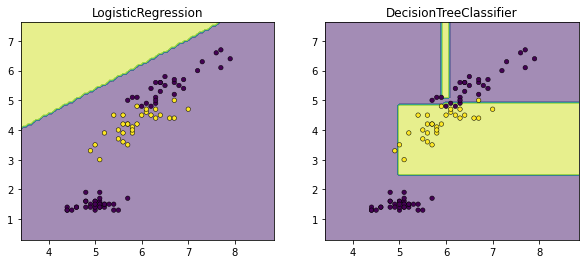

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

lr = LogisticRegression()
lr.fit(X_train, y_train)

dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_classifier_decision_zone(lr, X_test, y_test, ax=ax[0], title="LogisticRegression")
plot_classifier_decision_zone(dt, X_test, y_test, ax=ax[1], title="DecisionTreeClassifier")

The logistic regression is not very stable on this sort of problem. No linear separator can work on this dataset. Let's dig into it.

## DecisionTreeLogisticRegression

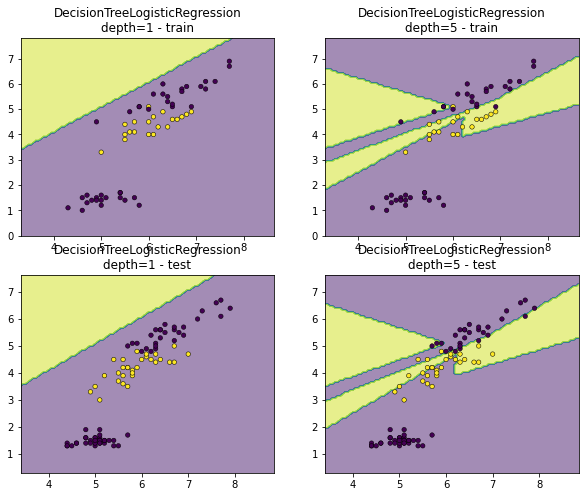

In [5]:
from mlinsights.mlmodel import DecisionTreeLogisticRegression

dtlr = DecisionTreeLogisticRegression(
    estimator=LogisticRegression(solver='liblinear'),
    min_samples_leaf=10, min_samples_split=10, max_depth=1,
    fit_improve_algo='none')
dtlr.fit(X_train, y_train)
dtlr2 = DecisionTreeLogisticRegression(
    estimator=LogisticRegression(solver='liblinear'),
    min_samples_leaf=4, min_samples_split=4, max_depth=10,
    fit_improve_algo='intercept_sort_always')
dtlr2.fit(X_train, y_train)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
plot_classifier_decision_zone(
    dtlr, X_train, y_train, ax=ax[0, 0],
    title="DecisionTreeLogisticRegression\ndepth=%d - train" % dtlr.tree_depth_)
plot_classifier_decision_zone(
    dtlr2, X_train, y_train, ax=ax[0, 1],
    title="DecisionTreeLogisticRegression\ndepth=%d - train" % dtlr2.tree_depth_)
plot_classifier_decision_zone(
    dtlr, X_test, y_test, ax=ax[1, 0],
    title="DecisionTreeLogisticRegression\ndepth=%d - test" % dtlr.tree_depth_)
plot_classifier_decision_zone(
    dtlr2, X_test, y_test, ax=ax[1, 1],
    title="DecisionTreeLogisticRegression\ndepth=%d - test" % dtlr2.tree_depth_)

In [6]:
from pandas import DataFrame

rows = []
for model in [lr, dt, dtlr, dtlr2]:
    val = (" - depth=%d" % model.tree_depth_) if hasattr(model, 'tree_depth_') else ""
    obs = dict(name="%s%s" % (model.__class__.__name__, val),
               score=model.score(X_test, y_test))
    rows.append(obs)

DataFrame(rows)

,name,score
0,LogisticRegression,0.666667
1,DecisionTreeClassifier,0.933333
2,DecisionTreeLogisticRegression - depth=1,0.666667
3,DecisionTreeLogisticRegression - depth=5,0.744444


## A first example

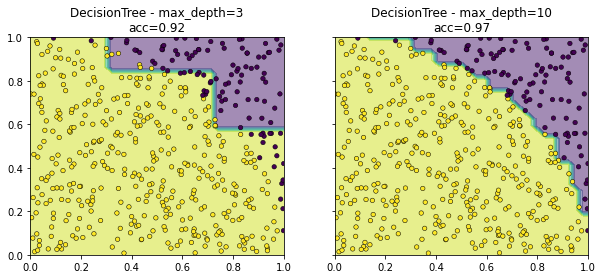

In [7]:
import numpy
from scipy.spatial.distance import cdist


def random_set_simple(n):
    X = numpy.random.rand(n, 2)
    y = ((X[:, 0] ** 2 + X[:, 1] ** 2) <= 1).astype(numpy.int32).ravel()
    return X, y

X, y = random_set_simple(2000)
X_train, X_test, y_train, y_test = train_test_split(X, y)
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
dt8 = DecisionTreeClassifier(max_depth=10)
dt8.fit(X_train, y_train)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_classifier_decision_zone(dt, X_test, y_test, ax=ax[0],
                              title="DecisionTree - max_depth=%d\nacc=%1.2f" % (
                                  dt.max_depth, dt.score(X_test, y_test)))
plot_classifier_decision_zone(dt8, X_test, y_test, ax=ax[1],
                              title="DecisionTree - max_depth=%d\nacc=%1.2f" % (
                                  dt8.max_depth, dt8.score(X_test, y_test)))
ax[0].set_xlim([0, 1])
ax[1].set_xlim([0, 1])
ax[0].set_ylim([0, 1]);

[DTLR ]   trained acc 0.96 N=1500
[DTLRI]   change intercept 11.456745 --> 10.515610 in [0.321064, 16.497657]
[DTLR*]  above: n_class=2 N=1500 - 1099/1500
[DTLR ]    trained acc 0.99 N=1099
[DTLRI]    change intercept 6.080103 --> 1.807076 in [0.069999, 2.621302]
[DTLR*]   above: n_class=1 N=1099 - 727/1500
[DTLR*]   below: n_class=2 N=1099 - 372/1500
[DTLR ]     trained acc 0.97 N=372
[DTLRI]     change intercept 4.182806 --> 0.882212 in [0.523840, 1.186326]
[DTLR*]  below: n_class=2 N=1500 - 401/1500
[DTLR ]    trained acc 0.74 N=401
[DTLRI]    change intercept 5.877007 --> 6.684701 in [5.927561, 9.363164]
[DTLR*]   above: n_class=2 N=401 - 166/1500
[DTLR ]     trained acc 0.64 N=166
[DTLRI]     change intercept 1.419100 --> 0.849523 in [0.795745, 0.912945]
[DTLR*]   below: n_class=1 N=401 - 235/1500


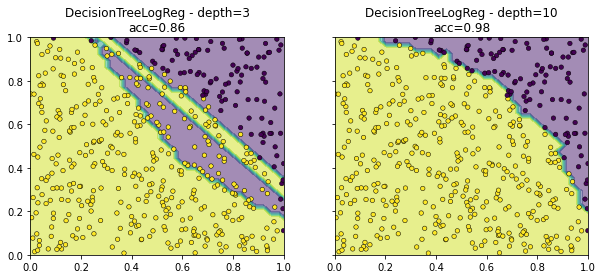

In [8]:
dtlr = DecisionTreeLogisticRegression(
    max_depth=3, fit_improve_algo='intercept_sort_always', verbose=1)
dtlr.fit(X_train, y_train)
dtlr8 = DecisionTreeLogisticRegression(
    max_depth=10, min_samples_split=4, fit_improve_algo='intercept_sort_always')
dtlr8.fit(X_train, y_train)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_classifier_decision_zone(dtlr, X_test, y_test, ax=ax[0],
                              title="DecisionTreeLogReg - depth=%d\nacc=%1.2f" % (
                                  dtlr.tree_depth_, dtlr.score(X_test, y_test)))
plot_classifier_decision_zone(dtlr8, X_test, y_test, ax=ax[1],
                              title="DecisionTreeLogReg - depth=%d\nacc=%1.2f" % (
                                  dtlr8.tree_depth_, dtlr8.score(X_test, y_test)))
ax[0].set_xlim([0, 1])
ax[1].set_xlim([0, 1])
ax[0].set_ylim([0, 1]);

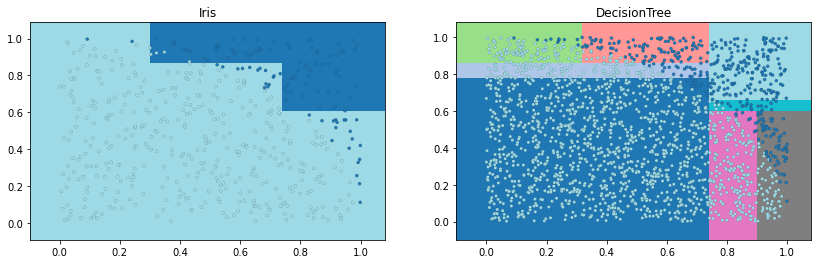

In [9]:
from mlinsights.mltree import predict_leaves


def draw_border(clr, X, y, fct=None, incx=0.1, incy=0.1,
                figsize=None, border=True, ax=None,
                s=10., linewidths=0.1):

    _unused_ = ["Red", "Green", "Yellow", "Blue", "Orange", "Purple", "Cyan",
              "Magenta", "Lime", "Pink", "Teal", "Lavender", "Brown", "Beige",
              "Maroon", "Mint", "Olive", "Coral", "Navy", "Grey", "White", "Black"]

    h = .02
    x_min, x_max = X[:, 0].min() - incx, X[:, 0].max() + incx
    y_min, y_max = X[:, 1].min() - incy, X[:, 1].max() + incy
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h), 
                            numpy.arange(y_min, y_max, h))
    if fct is None:
        Z = clr.predict(numpy.c_[xx.ravel(), yy.ravel()])
    else:
        Z = fct(clr, numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    cmap = plt.cm.tab20
    Z = Z.reshape(xx.shape)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize or (4, 3))
    ax.pcolormesh(xx, yy, Z, cmap=cmap)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k',
               cmap=cmap, s=s, linewidths=linewidths)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax


fig, ax = plt.subplots(1, 2, figsize=(14,4))
draw_border(dt, X_test, y_test, border=False, ax=ax[0])
ax[0].set_title("Iris")
draw_border(dt, X, y, border=False, ax=ax[1],
            fct=lambda m, x: predict_leaves(m, x))
ax[1].set_title("DecisionTree");

6it [00:02,  2.33it/s]


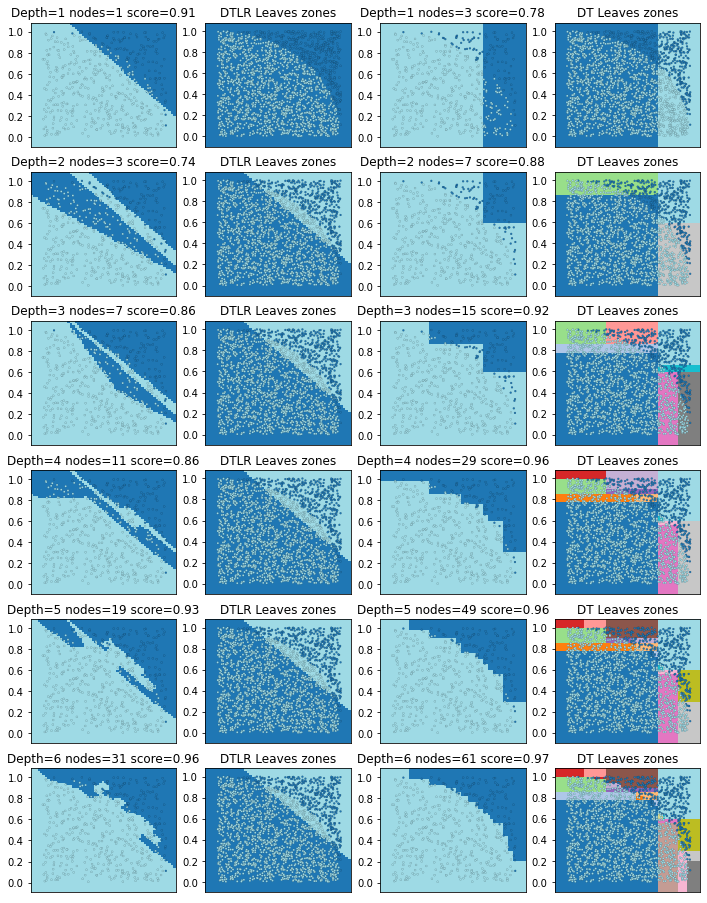

In [10]:
from tqdm import tqdm

fig, ax = plt.subplots(6, 4, figsize=(12, 16))
for i, depth in tqdm(enumerate((1, 2, 3, 4, 5, 6))):
    dtl = DecisionTreeLogisticRegression(
        max_depth=depth, fit_improve_algo='intercept_sort_always',
        min_samples_leaf=2)
    dtl.fit(X_train, y_train)
    draw_border(dtl, X_test, y_test, border=False, ax=ax[i, 0], s=4.)
    draw_border(dtl, X, y, border=False, ax=ax[i, 1],
                fct=lambda m, x: predict_leaves(m, x), s=4.)
    ax[i, 0].set_title("Depth=%d nodes=%d score=%1.2f" % (
        dtl.tree_depth_, dtl.n_nodes_, dtl.score(X_test, y_test)))
    ax[i, 1].set_title("DTLR Leaves zones");
    
    dtl = DecisionTreeClassifier(max_depth=depth)
    dtl.fit(X_train, y_train)
    draw_border(dtl, X_test, y_test, border=False, ax=ax[i, 2], s=4.)
    draw_border(dtl, X, y, border=False, ax=ax[i, 3],
                fct=lambda m, x: predict_leaves(m, x), s=4.)
    ax[i, 2].set_title("Depth=%d nodes=%d score=%1.2f" % (
        dtl.max_depth, dtl.tree_.node_count, dtl.score(X_test, y_test)))
    ax[i, 3].set_title("DT Leaves zones");    

    for k in range(ax.shape[1]):
        ax[i, k].get_xaxis().set_visible(False)

## Another example designed to fail

Designed to be difficult with a regular decision tree.

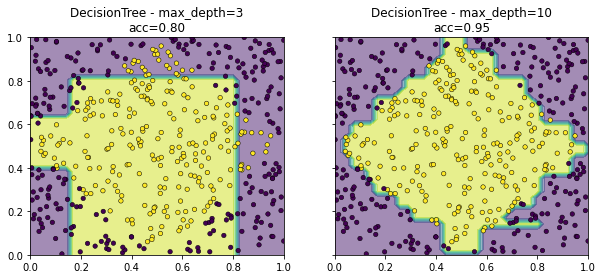

In [11]:
from scipy.spatial.distance import cdist

def random_set(n):
    X = numpy.random.rand(n, 2)
    y = (cdist(X, numpy.array([[0.5, 0.5]]),
               metric='minkowski', p=1) <= 0.5).astype(numpy.int32).ravel()
    return X, y

X, y = random_set(2000)
X_train, X_test, y_train, y_test = train_test_split(X, y)
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
dt8 = DecisionTreeClassifier(max_depth=10)
dt8.fit(X_train, y_train)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_classifier_decision_zone(dt, X_test, y_test, ax=ax[0],
                              title="DecisionTree - max_depth=%d\nacc=%1.2f" % (
                                  dt.max_depth, dt.score(X_test, y_test)))
plot_classifier_decision_zone(dt8, X_test, y_test, ax=ax[1],
                              title="DecisionTree - max_depth=%d\nacc=%1.2f" % (
                                  dt8.max_depth, dt8.score(X_test, y_test)))
ax[0].set_xlim([0, 1])
ax[1].set_xlim([0, 1])
ax[0].set_ylim([0, 1]);

The example is a square rotated by 45 degrees. Every sample in the square is a positive sample, every sample outside is a negative one. The tree approximates the border with horizontal and vertical lines.

[DTLR ]   trained acc 0.44 N=1500
[DTLRI]   change intercept -0.034942 --> 0.002299 in [-0.096825, 0.100018]
[DTLR*]  above: n_class=2 N=1500 - 749/1500
[DTLR ]    trained acc 0.63 N=749
[DTLRI]    change intercept 0.482240 --> 0.419857 in [-0.721736, 2.201494]
[DTLR*]   above: n_class=2 N=749 - 381/1500
[DTLR ]     trained acc 0.60 N=381
[DTLRI]     change intercept 0.013635 --> -0.409886 in [-0.845454, -0.000891]
[DTLR*]   below: n_class=2 N=749 - 368/1500
[DTLR ]     trained acc 0.80 N=368
[DTLRI]     change intercept 1.441197 --> 1.676946 in [0.805396, 4.043436]
[DTLR*]  below: n_class=2 N=1500 - 751/1500
[DTLR ]    trained acc 0.63 N=751
[DTLRI]    change intercept 1.136591 --> 1.144781 in [0.080860, 2.981936]
[DTLR*]   above: n_class=2 N=751 - 379/1500
[DTLR ]     trained acc 0.61 N=379
[DTLRI]     change intercept 0.429965 --> -0.014327 in [-0.309987, 0.284766]
[DTLR*]   below: n_class=2 N=751 - 372/1500
[DTLR ]     trained acc 0.71 N=372
[DTLRI]     change intercept 2.106241 --

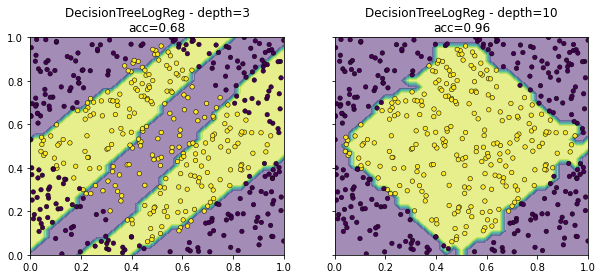

In [12]:
dtlr = DecisionTreeLogisticRegression(
    max_depth=3, fit_improve_algo='intercept_sort_always', verbose=1)
dtlr.fit(X_train, y_train)
dtlr8 = DecisionTreeLogisticRegression(
    max_depth=10, min_samples_split=4, fit_improve_algo='intercept_sort_always')
dtlr8.fit(X_train, y_train)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_classifier_decision_zone(dtlr, X_test, y_test, ax=ax[0],
                              title="DecisionTreeLogReg - depth=%d\nacc=%1.2f" % (
                                  dtlr.tree_depth_, dtlr.score(X_test, y_test)))
plot_classifier_decision_zone(dtlr8, X_test, y_test, ax=ax[1],
                              title="DecisionTreeLogReg - depth=%d\nacc=%1.2f" % (
                                  dtlr8.tree_depth_, dtlr8.score(X_test, y_test)))
ax[0].set_xlim([0, 1])
ax[1].set_xlim([0, 1])
ax[0].set_ylim([0, 1]);

## Leave zones

We use method *decision_path* to understand which leaf is responsible for which zone.

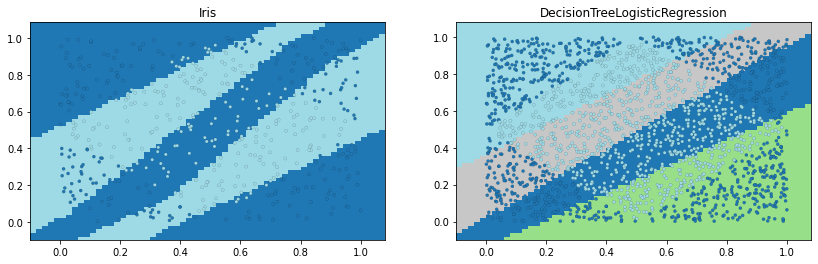

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
draw_border(dtlr, X_test, y_test, border=False, ax=ax[0])
ax[0].set_title("Iris")
draw_border(dtlr, X, y, border=False, ax=ax[1],
            fct=lambda m, x: predict_leaves(m, x))
ax[1].set_title("DecisionTreeLogisticRegression");

6it [00:02,  1.93it/s]


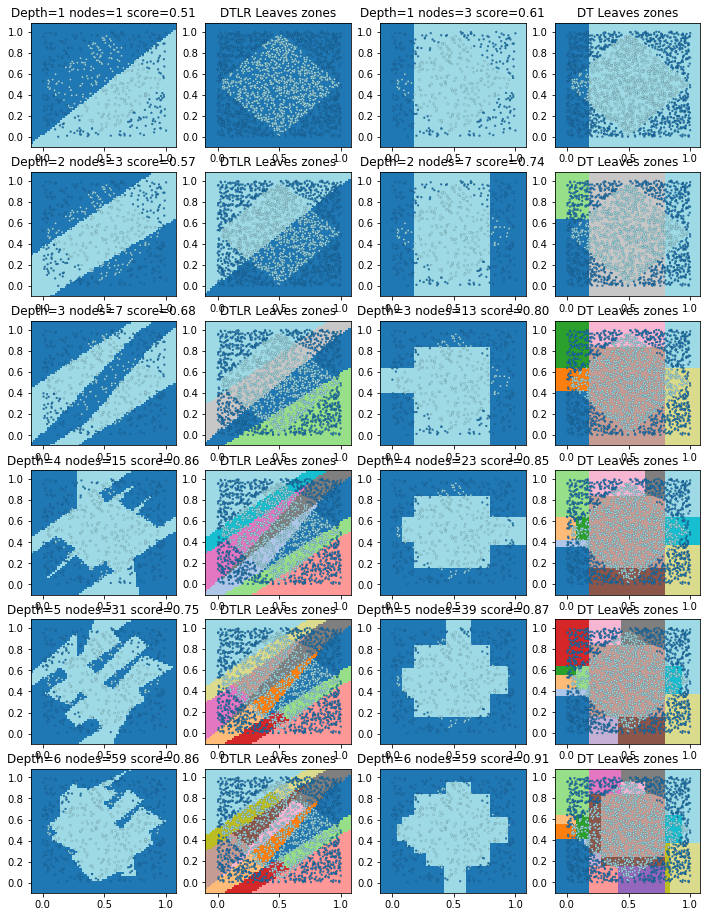

In [14]:
from tqdm import tqdm

fig, ax = plt.subplots(6, 4, figsize=(12, 16))
for i, depth in tqdm(enumerate((1, 2, 3, 4, 5, 6))):
    dtl = DecisionTreeLogisticRegression(
        max_depth=depth, fit_improve_algo='intercept_sort_always',
        min_samples_leaf=2)
    dtl.fit(X_train, y_train)
    draw_border(dtl, X_test, y_test, border=False, ax=ax[i, 0], s=4.)
    draw_border(dtl, X, y, border=False, ax=ax[i, 1],
                fct=lambda m, x: predict_leaves(m, x), s=4.)
    ax[i, 0].set_title("Depth=%d nodes=%d score=%1.2f" % (
        dtl.tree_depth_, dtl.n_nodes_, dtl.score(X_test, y_test)))
    ax[i, 1].set_title("DTLR Leaves zones");
    
    dtl = DecisionTreeClassifier(max_depth=depth)
    dtl.fit(X_train, y_train)
    draw_border(dtl, X_test, y_test, border=False, ax=ax[i, 2], s=4.)
    draw_border(dtl, X, y, border=False, ax=ax[i, 3],
                fct=lambda m, x: predict_leaves(m, x), s=4.)
    ax[i, 2].set_title("Depth=%d nodes=%d score=%1.2f" % (
        dtl.max_depth, dtl.tree_.node_count, dtl.score(X_test, y_test)))
    ax[i, 3].set_title("DT Leaves zones");    